# Data Science 1 - Home Assignment 2

**Author: Márton Nagy**

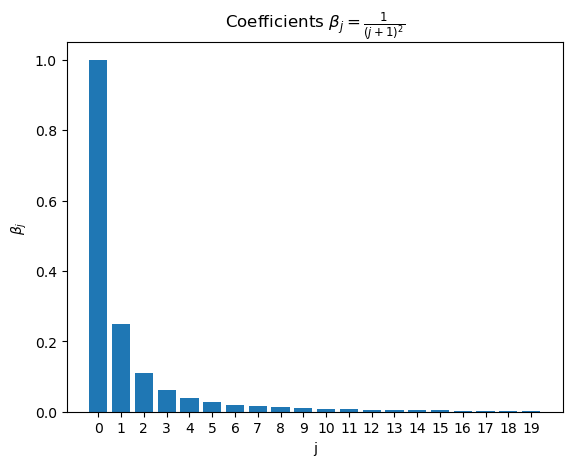

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex
import matplotlib.cm as cm
from plotnine import *
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

import warnings
warnings.filterwarnings('ignore')
prng = np.random.RandomState(20250310)

def generateBeta(n_features):
    return [1/(j + 1)**2 for j in range(n_features)]
def generateData(n_samples, n_features, prng):
    X = pd.DataFrame(prng.multivariate_normal(
    mean=np.repeat(0, n_features),
    cov=np.eye(n_features),
    size=n_samples
    ))
    beta = generateBeta(n_features)
    y = np.dot(X, beta) + prng.normal(0, 1, size=n_samples)
    return X, y

p = 20
plt.bar(range(p), generateBeta(p))
plt.xlabel('j')
plt.xticks(range(p))
plt.ylabel(r'$\beta_{j}$')
plt.title(r'Coefficients $\beta_{j}=\frac{1}{(j+1)^{2}}$')
plt.show()

# Task 1

**Description**: Generate a single dataset with 20 features and 100 observations using the provided function: generateData(100, 20, prng).

In [2]:
X, y = generateData(100, 20, prng)

**Answer**: I generate a single dataset with 20 features and 100 observations using the provided function. There is nothing more to explain.

# Task 2

**Description**: . Implement Lasso regression with cross-validation to determine the optimal regularization parameter (alpha). Select an appropriate number of cross-validation folds and provide justification for your choice, considering both statistical validity and computational efficiency.

In [3]:
lasso_cv = GridSearchCV(
    Lasso(random_state=prng),
    param_grid={'alpha': np.linspace(0.01, 1, 100)},
    scoring='neg_mean_squared_error',
    cv=10,
    refit=True
    ).fit(X, y)

print(f'The optimal regularization parameter is: {lasso_cv.best_params_['alpha']:0.2f}')

The optimal regularization parameter is: 0.06


**Answer**: As X values have a mean of zero and standard deviation of 1 by definition, there is no need to scale them for LASSO. I decided to do a 10-fold cross-validation, as this way each fold will have 90 observations to learn the patterns and 10 observations to evaluate them. This is sound from a statistical point of view, as we can expect reasonable variation in the left-out 10% of observations to be able to properly test the models' validity, but it is also computationally feasible (even if we would later decide to scale the sample size drastically). I search over $\lambda$ parameters in the 0 to 1 range (the selected optimal value is 0.06). As we will later see, all coefficients are shrunk to zero at the end of this range, so there is no need to extend it.

# Task 3

**Description**: Create a plot displaying the Mean Squared Error (MSE) for each candidate regularization parameter, evaluated across all cross-validation folds. Include
individual MSE values for each fold and the average MSE across folds for each parameter value, and highlight the optimal value of the regularization parameter. Briefly interpret your results.

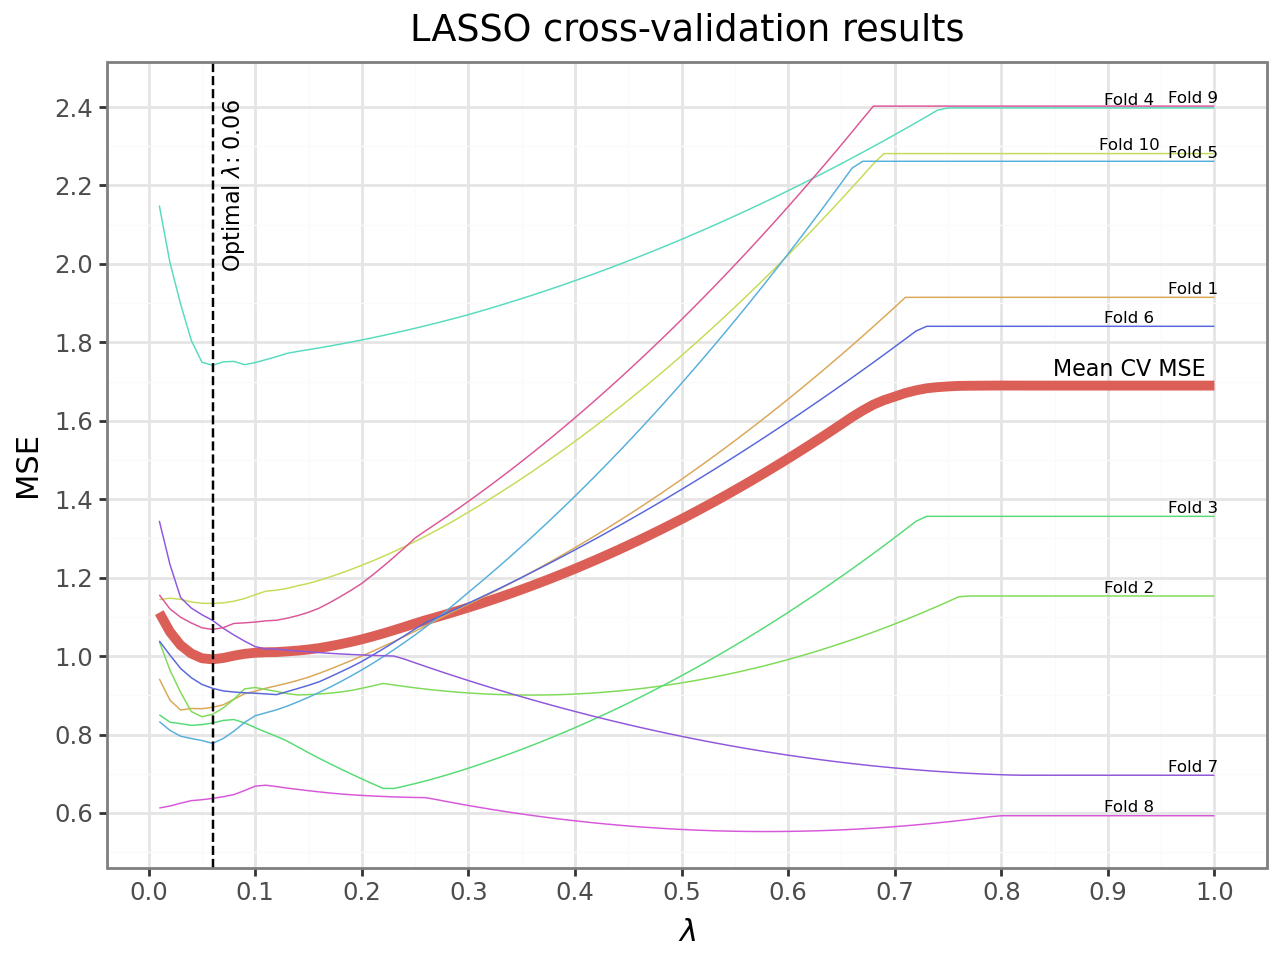

In [4]:
cv_data = {
    'Lambda': lasso_cv.cv_results_['param_alpha'],
    'CV mean' : -lasso_cv.cv_results_['mean_test_score'],
}

for i in range(0,10):
    cv_data[f'Fold {i+1}'] = -lasso_cv.cv_results_[f'split{i}_test_score']

cv_data = pd.melt(pd.DataFrame(cv_data), id_vars=['Lambda'], value_vars=pd.DataFrame(cv_data).columns[1:])

p = (
    ggplot(cv_data, aes(x='Lambda', y='value', color='variable', size=(cv_data['variable'] == 'CV mean')))
    + geom_line()
    + geom_vline(xintercept=lasso_cv.best_params_['alpha'], linetype='dashed', color = 'black')
    + theme_bw()
    + scale_size_manual(values=[0.3, 2])
    + scale_x_continuous(breaks=np.linspace(0, 1, 11))
    + scale_y_continuous(breaks=np.linspace(0, 2.4, 13))
    + labs(x=r'$\lambda$', y='MSE', title='LASSO cross-validation results')
    + theme(legend_position='none')
)

for i in range(0,10):
    p = p + annotate('text',
                     x=lasso_cv.cv_results_['param_alpha'][-3 if i % 2 == 0 else -9],
                     y=-lasso_cv.cv_results_[f'split{i}_test_score'][-1]+0.02,
                     label=f'Fold {i+1}',
                     color='black',
                     size=6)

p = p + annotate('text',
                 x=lasso_cv.cv_results_['param_alpha'][-9],
                 y=-lasso_cv.cv_results_[f'mean_test_score'][-1]+0.04,
                 label=f'Mean CV MSE',
                 color='black',
                 size=8)
p = p + annotate('text',
                 x=lasso_cv.best_params_['alpha']+0.02,
                 y=2.2,
                 label=r'Optimal $\lambda$: ' + f'{lasso_cv.best_params_["alpha"]:.2f}',
                 color='black',
                 angle=90,
                 size=8)
p

**Answer**: From the above plot, we can see that the best LASSO model needs a relatively low level of regularization, as the best $\lambda$ value is only 0.06. This corresponds to an average MSE of 0.992 (that is an RMSE of 0.996), meaning that our predictions are off by roughly 1 unit on average. As mentioned before, the MSE values become a flat line after appr. $\lambda=0.8$, meaning that after this point, all coefficients are shrunk to zero, and we are simply predicting the mean.

# Task 4:

**Description**: Generate a coefficient path plot that illustrates how feature coefficients change as the regularization parameter varies. Briefly interpret your results.

**Technical notes**: To generate such a plot, we cannot really use the cross-validation results, as in each fold, the coefficients are different for the same $\lambda$. Therefore, I calculate the LASSO coefficients for each $\lambda$ on the whole dataset, and plot these results. As it is quite hard to identify which feature is which color (given that we have 20 features), I also create another plot which shows what is the maximum $\lambda$ per feature, for which the coefficient is not zero.

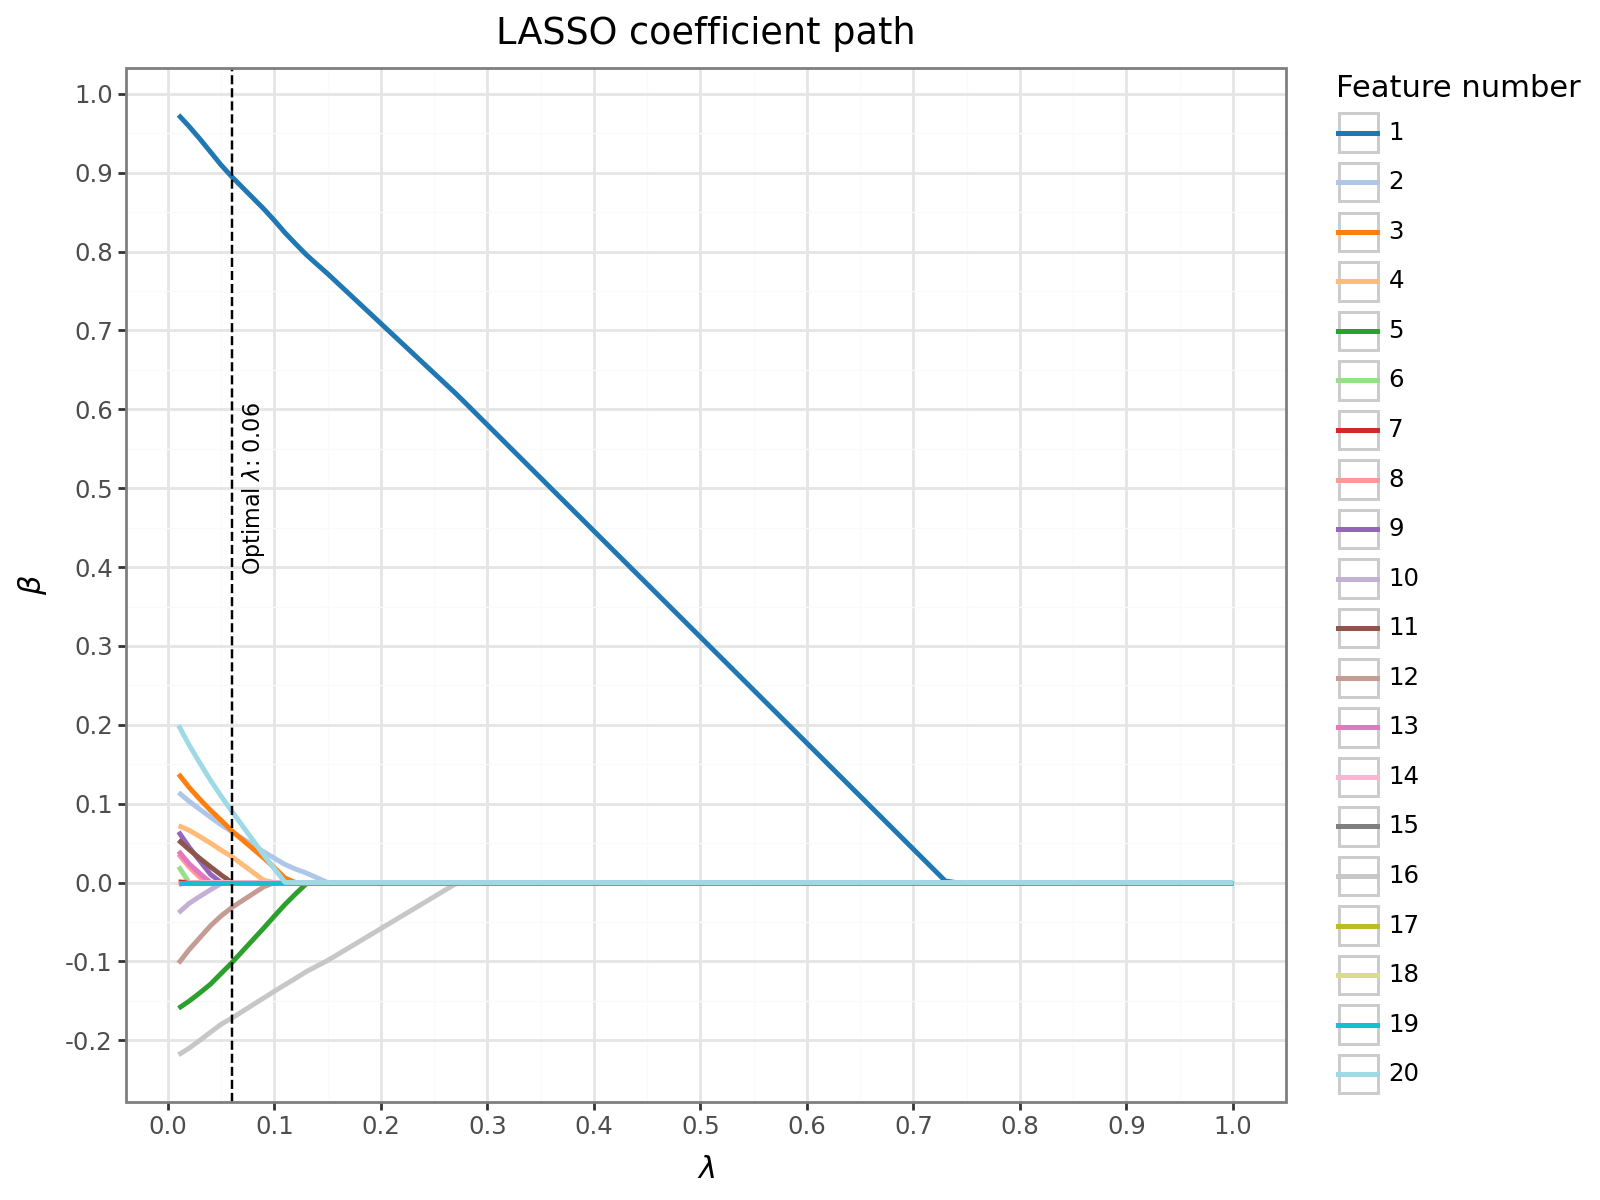

In [5]:
coef_path_data = pd.DataFrame({'j': [], 'beta_j': [], 'lambda': []})
for a in np.linspace(0.01, 1, 100):
    lasso = Lasso(alpha=a, random_state=prng).fit(X, y)
    lasso_coef = pd.DataFrame({'j': range(1,21), 'beta_j': lasso.coef_})
    lasso_coef['lambda'] = a
    coef_path_data = pd.concat([coef_path_data, lasso_coef])
coef_path_data['j'] = pd.Categorical(coef_path_data['j'], ordered=True)
integer_labels = [str(int(j)) for j in coef_path_data['j'].unique()]
cmap = cm.get_cmap("tab20", 20)
color_palette = [to_hex(cmap(i)) for i in range(20)]
(
    ggplot(coef_path_data, aes(x='lambda', y='beta_j', color='j'))
    + geom_line(size = 1)
    + theme_bw()
    + scale_x_continuous(breaks=np.linspace(0, 1, 11))
    + scale_y_continuous(breaks=np.linspace(-0.2, 1, 13))
    + scale_color_manual(values=color_palette, labels=integer_labels)
    + geom_vline(xintercept=lasso_cv.best_params_['alpha'], linetype='dashed', color = 'black')
    + annotate('text', x=lasso_cv.best_params_['alpha']+0.02, y=0.5,
               label=r'Optimal $\lambda$: ' + f'{lasso_cv.best_params_["alpha"]:.2f}', color='black',
               angle=90, size=8)
    + theme(figure_size=(8, 6))
    + labs(x=r'$\lambda$', y=r'$\beta$', title='LASSO coefficient path', color='Feature number')
)

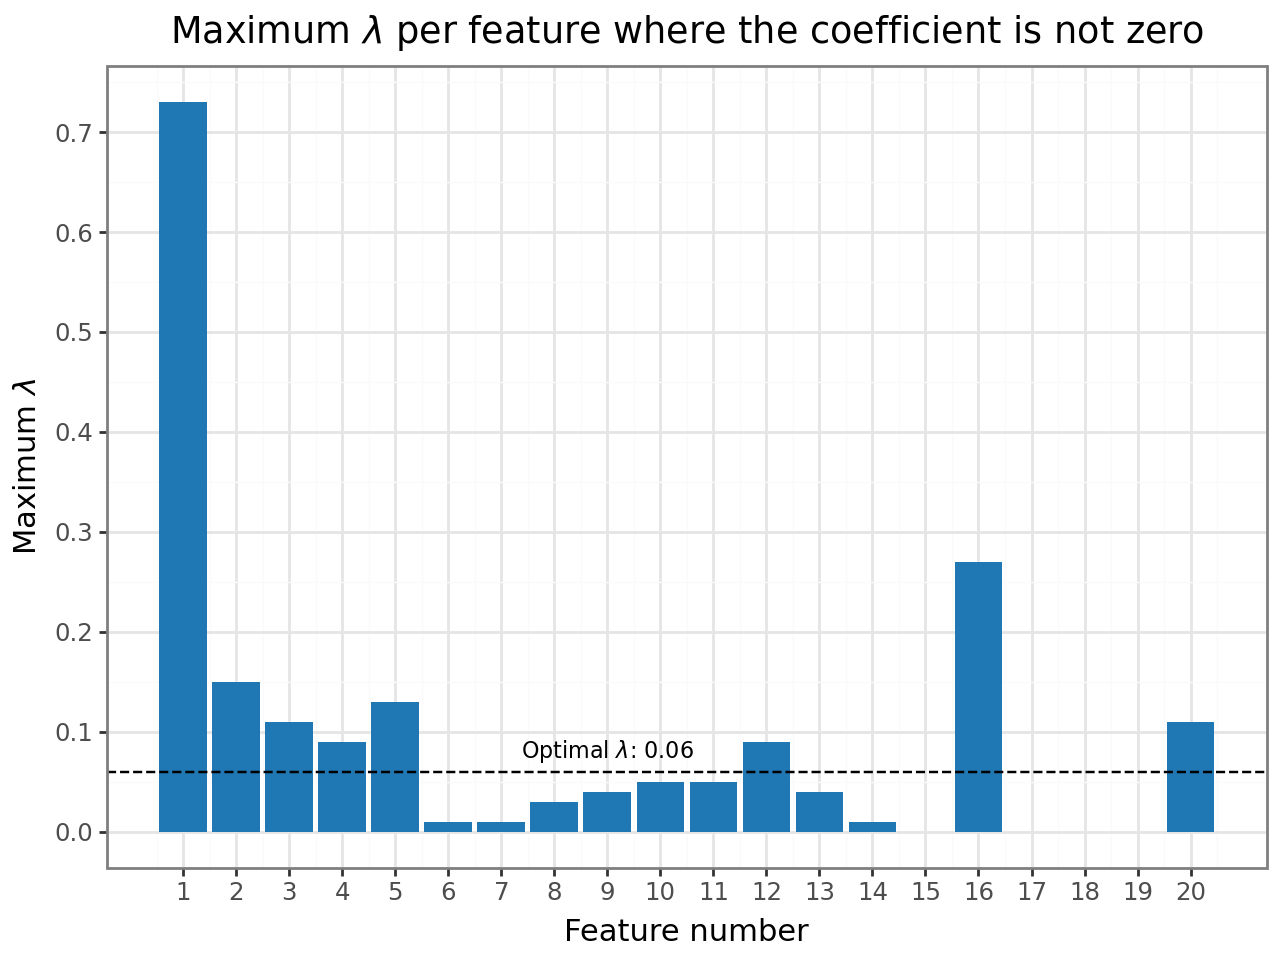

In [6]:
max_lambda_per_coef = (
    coef_path_data[coef_path_data['beta_j'] != 0]
    .groupby('j')['lambda']
    .max()
    .reset_index()
    .rename(columns={'lambda': 'max_lambda'})
)

max_lambda_per_coef['max_lambda'].fillna(0, inplace=True)
max_lambda_per_coef['j'] = max_lambda_per_coef['j'].astype(int)

(
    ggplot(max_lambda_per_coef, aes(x='j', y='max_lambda'))
    + geom_col(fill = color_palette[0])
    + geom_hline(yintercept=lasso_cv.best_params_['alpha'], linetype='dashed', color = 'black')
    + annotate('text', y=lasso_cv.best_params_['alpha']+0.02, x=9,
               label=r'Optimal $\lambda$: ' + f'{lasso_cv.best_params_["alpha"]:.2f}', color='black', size=8)
    + theme_bw()
    + scale_x_continuous(breaks=range(1, 21))
    + scale_y_continuous(breaks=np.linspace(0, 1, 11))
    + labs(x='Feature number', y=r'Maximum $\lambda$', title=r'Maximum $\lambda$ per feature where the coefficient is not zero')
)


**Answer**: As we can clearly see from both plots, the feature that is shrunk to zero the latest (and thus has the largest coefficient) is the first one - this good news, as this represents the true data generating process closely. Features 2, 3, 4 and 5 are also important in the models (but a lot less so then the first feature, as it can be seen on the coefficient path plot that their coefficient values are much smaller than that of feature 1), which is again in line with our expectations. However, the second most important feature in this sense is the $16^{th}$, and features 12 and 20 are also kept in the model at the optimal $\lambda$ value. This suggests that LASSO selects only a few of the features that are have very low coefficient values in the true process, but it is quite arbitrary which ones are these features.